# Detangled: a tool to pinpoint student confusion
by Enya, Erina, and Laura

## About
Short description

## How to use
1. Step one
2. Step two
3. Step three

In [2]:
# setup environment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import csv
#import plotly.graph_objects as go

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import matplotlib.font_manager
from matplotlib import cm

In [3]:
# Create random rbric data
studentid = []
for i in range(100):
    studentid.append( ''.join([random.choice(string.digits) for n in range(5)]))

enA = [np.random.choice([0, 1], p=[0.8, 0.2]) for x in range(100)]
enB = [np.random.choice([0, 1], p=[0.9, 0.1]) for x in range(100)]
enC = [np.random.choice([0, 1], p=[0.7, 0.3]) for x in range(100)]

kinA = [np.random.choice([0, 1], p=[0.95, 0.05]) for x in range(100)]
kinB = [np.random.choice([0, 1], p=[0.9, 0.1]) for x in range(100)]
kinC = [np.random.choice([0, 1], p=[0.93, 0.07]) for x in range(100)]

matA = [np.random.choice([0, 1, 2, 3], p=[0.65, 0.1, 0.15, 0.1]) for x in range(1000)]
matB = [np.random.choice([0, 1, 2, 3], p=[0.8, 0.05, 0.1, 0.05]) for x in range(100)]
matC = [np.random.choice([0, 1, 2, 3], p=[0.88, 0.09, 0.01, 0.02]) for x in range(100)]

grA = [np.random.choice([0, 1], p=[0.8, 0.2]) for x in range(100)]
grB = [np.random.choice([0, 1], p=[0.9, 0.1]) for x in range(100)]
grC = [np.random.choice([0, 1], p=[0.7, 0.3]) for x in range(100)]
                         
dimA = [np.random.choice([0, 1], p=[0.6, 0.4]) for x in range(100)]
dimB = [np.random.choice([0, 1], p=[0.9, 0.1]) for x in range(100)]
dimC = [np.random.choice([0, 1], p=[0.7, 0.3]) for x in range(100)]

headerList = ['student', "energyA", "energyB", "energyC", "kinematicsA","kinematicsB","kinematicsC",
              "mathA", "mathB", "mathC", "graphA", "graphB", "graphC", "dimA", "dimB", "dimC"]

with open('rubric.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headerList)
    for i in range(100):
        row = [studentid[i], enA[i], enB[i], enC[i], kinA[i], kinB[i], kinC[i], matA[i], matB[i], matC[i], 
              grA[i], grB[i], grC[i], dimA[i], dimB[i], dimC[i]]
        writer.writerow(row)

In [4]:
# read csv file to extract concepts and student data
# student 0 or first line of data is max scores

fname = r'test.csv'
df = pd.read_csv(fname)
concepts = list(df.columns[1:])
students = list(df["student"])
ids = df.index.tolist()
tot_stud = len(ids) - 1
maxscores = {idx:float(df[idx][0]) for idx in concepts}

In [107]:
# inital test breakdown: find students who lost points in each category
# breakdown percentage: % of total students who lost points in each category weighted by number of points lost

test_bd = {}
for idx in concepts:
    test_bd[idx] = {}
    for i in ids[1:]:
        if f'{df[idx][i]}' != str(0):
            test_bd[idx][f'{df["student"][i]}'] = float(df[idx][i])/maxscores[idx]

test_bd_pct = {}
for idx in test_bd:
    test_bd_pct[idx] = round(sum([test_bd[idx][i] for i in test_bd[idx]])/tot_stud, 3)
    

In [108]:
# topic-based breakdown: find correlations within each topic

topic_bd = []
topic_bd_pct = {}
for idx in concepts:
    s = len(test_bd[idx])
    temp = [x for x in concepts if x != idx]
    for i in range(len(temp)):
        corr = [test_bd[idx][v]*test_bd[temp[i]][v] for v in test_bd[idx] if v in test_bd[temp[i]]]
        n = f'{idx}_{temp[i]}'
        topic_bd.append({n:corr})
#         print(idx,temp[i],corr,s)
        topic_bd_pct[n] = round(sum(corr)/s, 3)


In [79]:
# displaying visualizations

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

<Figure size 432x288 with 0 Axes>

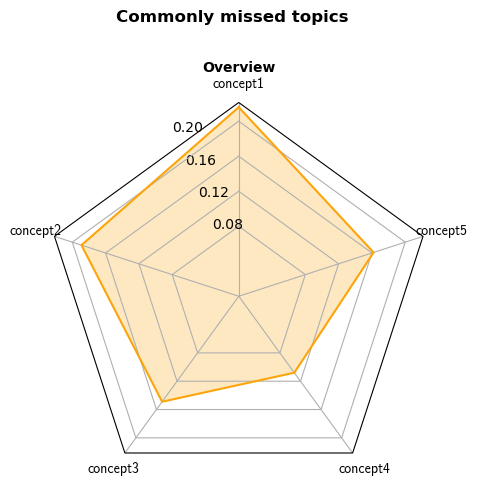

In [112]:
if __name__ == '__main__':
#     data = [
#         (concepts,'Overview', [[test_bd_pct[k] for k in concepts]]),
#         (concepts[1:],'With Concept1', [[topic_bd_pct[concepts[0]+f'_{k}'] for k in concepts[1:]]]),
#     ]
    data = [concepts,'Overview', [[test_bd_pct[k] for k in concepts]]]
#     data = [
#         (concepts[1:],'With Concept1', [[topic_bd_pct[concepts[0]+f'_{k}'] for k in concepts[1:]]])
#     ]
    
    plt.clf()
    
    cmap = cm.get_cmap('inferno')
    spoke_labels, title, case_data = data
    theta = radar_factory(len(spoke_labels), frame='polygon')

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, case_data[0], color=cmap(0.8))
    ax.fill(theta, case_data[0], facecolor=cmap(0.8), alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.set_rgrids([0.08 + 0.04*i for i in range(4)])
#     print(len(spoke_labels))
#     print(ax.get_xticklabels())
    for tick in ax.get_xticklabels():
        tick.set_fontname("cmss10")

    # add legend relative to top-left plot
#     labels = ()
#     legend = axs[1].legend(labels, loc=(0.9, .95), labelspacing=0.1, fontsize='small')

    fig.text(0.5, 1, 'Commonly missed topics', horizontalalignment='center', color='black', weight='bold', size='large')
    
    fig.set_dpi(100)
    plt.show()

<Figure size 432x288 with 0 Axes>

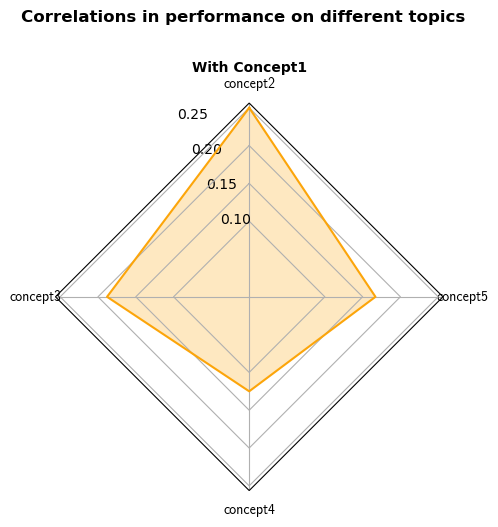

In [110]:
data = [concepts[1:],'With Concept1', [topic_bd_pct[concepts[0]+f'_{k}'] for k in concepts[1:]]]
    
plt.clf()
    
cmap = cm.get_cmap('inferno')

spoke_labels, title, case_data = data
theta = radar_factory(len(spoke_labels), frame='polygon')

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),horizontalalignment='center', verticalalignment='center')
ax.plot(theta, case_data, color=cmap(0.8))
ax.fill(theta, case_data, facecolor=cmap(0.8), alpha=0.25, label='_nolegend_')
ax.set_varlabels(spoke_labels)
ax.set_rgrids([0.1, 0.15, 0.2, 0.25])
for tick in ax.get_xticklabels():
    tick.set_fontname("cmss10")

    # add legend relative to top-left plot
#     labels = ()
#     legend = axs[1].legend(labels, loc=(0.9, .95), labelspacing=0.1, fontsize='small')

fig.text(0.5, 1, 'Correlations in performance on different topics', horizontalalignment='center', color='black', weight='bold', size='large')
    
fig.set_dpi(100)
plt.show()